# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
# install the airport data library
# !pip install airportsdata
# !pip install imblearn

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn
# !pip install xgboost

In [2]:
import imblearn

In [3]:
import pandas as pd
from airportsdata import load
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier


In [4]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [5]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

### Create new Columns

In [7]:
# Create lead_bucket columns that converts purchase_lead to categorical ranges
lead_bins = [0, 7, 30, 90, float('inf')]
lead_labels = ['0–7', '8–30', '31–90', '90+']

df['lead_bucket'] = pd.cut(df['purchase_lead'], bins=lead_bins, labels=lead_labels, right=True, include_lowest=True)

In [8]:
# Create long_stay Boolean from length_of_stay
# 75th percentile of length_of_stay is a resonable value to set as threshold

threshold = df['length_of_stay'].describe()["75%"]

df['long_stay'] = df['length_of_stay'] > threshold

df['long_stay'] = df['long_stay'].astype(int)

In [9]:
# Based on flight_day (Mon, Tue...), capture if a flight is on a weekend
df['is_weekend_flight'] = df['flight_day'].isin(['Sat', 'Sun']).astype(int)

In [10]:
# Group flight_hour into buckets:
def flight_time_bucket(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 22:
        return 'Evening'
    else:
        return 'Night'

df['flight_time_bucket'] = df['flight_hour'].apply(flight_time_bucket)

In [11]:
# Count of Optional Extras Chosen
df['num_optional_extras'] = (
    df['wants_extra_baggage'] +
    df['wants_preferred_seat'] +
    df['wants_in_flight_meals']
)

In [12]:
# Load IATA airport data
airports = load('IATA')  # returns a dictionary keyed by IATA code


# Define lookup function
def get_country(airports: dict, iata_code: str) -> str:
    info = airports.get(iata_code)
    return info['country'] if info else None

In [13]:
# Split route column into origin and destination airport codes
df['origin_airport'] = df['route'].str[:3]
df['destination_airport'] = df['route'].str[-3:]

# Map airport codes to country names
df['origin_country'] = df['origin_airport'].apply(lambda code: get_country(airports, code))
df['destination_country'] = df['destination_airport'].apply(lambda code: get_country(airports, code))

# Create is_domestic column
df['is_domestic'] = (df['origin_country'] == df['destination_country']).astype(int)

In [14]:
df['is_domestic'].unique()

array([0])

This tells us that all the data in this dataset are for international flights.

### Pre-model Visualizations

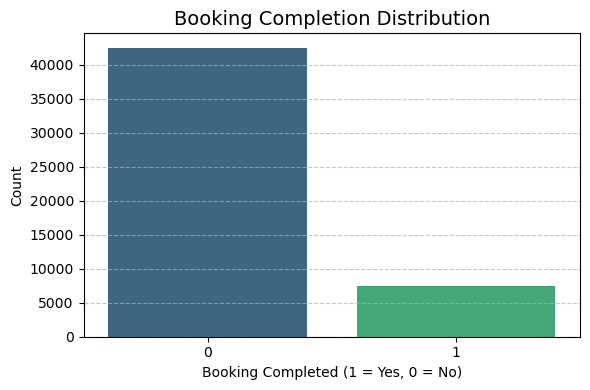

In [15]:
# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='booking_complete', data=df, palette='viridis')
plt.title('Booking Completion Distribution', fontsize=14)
plt.xlabel('Booking Completed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

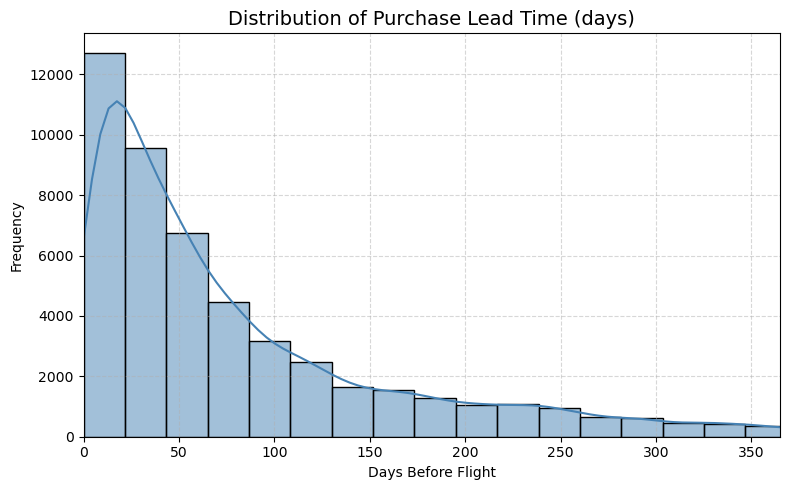

In [16]:
# Lead Time Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['purchase_lead'], bins=40, kde=True, color='steelblue')
plt.title('Distribution of Purchase Lead Time (days)', fontsize=14)
plt.xlabel('Days Before Flight')
plt.ylabel('Frequency')
plt.xlim(0, 365)  # 👈 Limits the x-axis to 0–365 days
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

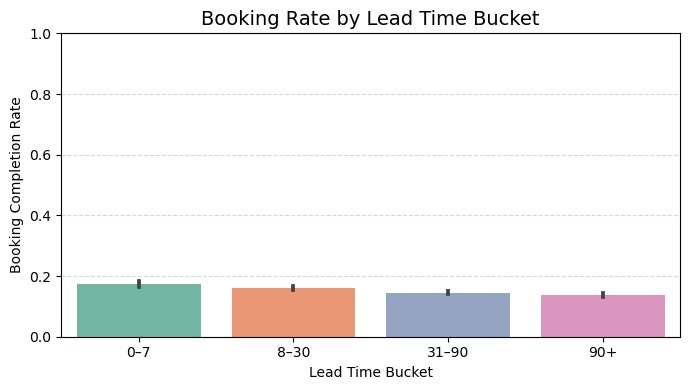

In [17]:
# Booking Completion by Lead Bucket
plt.figure(figsize=(7, 4))
sns.barplot(x='lead_bucket', y='booking_complete', data=df, palette='Set2')
plt.title('Booking Rate by Lead Time Bucket', fontsize=14)
plt.xlabel('Lead Time Bucket')
plt.ylabel('Booking Completion Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

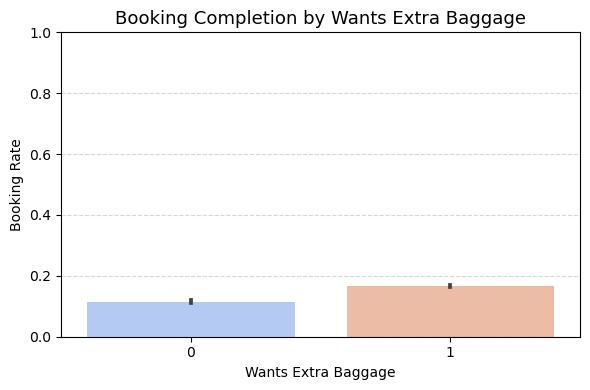

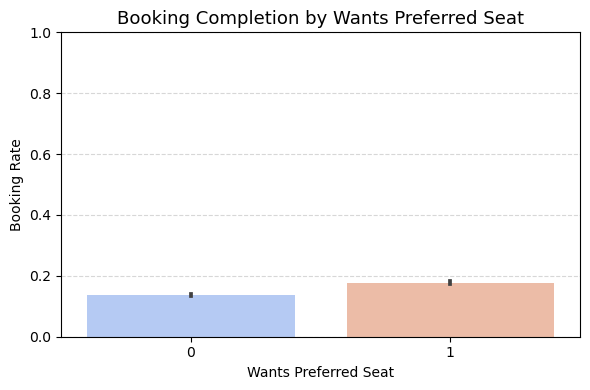

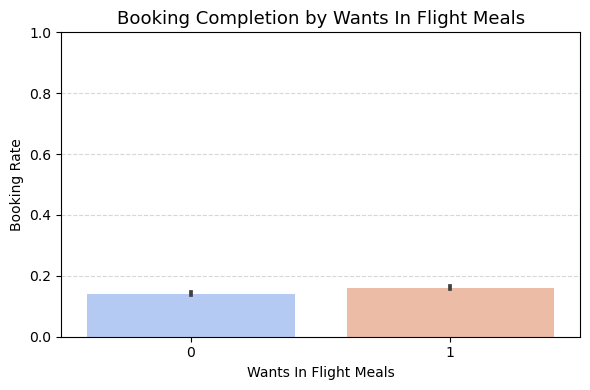

In [18]:
# Booking Completion by Extra Services
services = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

for col in services:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=col, y='booking_complete', data=df, palette='coolwarm')
    plt.title(f'Booking Completion by {col.replace("_", " ").title()}', fontsize=13)
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Booking Rate')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Data Conversion 

In [19]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [20]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [21]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [22]:
mapping = {
    "Internet": 1,
    "Mobile": 2
}

df["sales_channel"] = df["sales_channel"].map(mapping)

In [23]:
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [24]:
mapping = {
    "RoundTrip": 1,
    "CircleTrip": 2,
    "OneWay": 3
}

df["trip_type"] = df["trip_type"].map(mapping)

In [25]:
# Map each route to the number of times it appears in the dataset. (Frequency Encoding)
route_freq = df["route"].value_counts().to_dict()
df["route"] = df["route"].map(route_freq)


In [26]:
df["booking_origin"].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

In [27]:
# Apply label encoding to booking_origin

# Create a label encoder instance
le = LabelEncoder()

# Fit and transform the 'booking_origin' column
df['booking_origin'] = le.fit_transform(df['booking_origin'])

In [28]:
len(df['booking_origin'].unique())

104

In [29]:
# map the lead_bucket to numerical values
lead_mapping = {'0–7': 0, '8–30': 1, '31–90': 2, '90+': 3}
df['lead_bucket'] = df['lead_bucket'].map(lead_mapping)

In [30]:
df['flight_time_bucket'].unique()

array(['Morning', 'Night', 'Afternoon', 'Evening'], dtype=object)

In [31]:
mapping = {
    "Morning": 1,
    "Night": 2,
    "Afternoon": 3, 
    "Evening": 4
}

df["flight_time_bucket"] = df["flight_time_bucket"].map(mapping)

In [32]:
# map the origin and destination airport codes to numerical values

# Combine both columns to get all unique airport codes
all_airports = pd.concat([df['origin_airport'], df['destination_airport']])

# Get unique airport codes and sort them for consistent mapping
unique_airports = all_airports.dropna().unique()
unique_airports.sort()

# Create a mapping: airport code → integer
airport_to_code = {airport: int(idx) for idx, airport in enumerate(unique_airports)}

# Apply mapping to both columns and cast to int
df['origin_airport_code'] = df['origin_airport'].map(airport_to_code).astype(int)
df['destination_airport_code'] = df['destination_airport'].map(airport_to_code).astype(int)

In [33]:
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,wants_in_flight_meals,flight_duration,booking_complete,long_stay,is_weekend_flight,flight_time_bucket,num_optional_extras,is_domestic,origin_airport_code,destination_airport_code
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000
mean,1.591240,1.112360,1.017800,84.940480,23.04456,9.06634,3.814420,404.939120,38.263340,0.668780,...,0.427140,7.277561,0.149560,0.24664,0.247320,1.923720,1.392880,0.0,35.495760,65.186520
std,1.020165,0.315812,0.181559,90.451378,33.88767,5.41266,1.992792,591.782184,32.756539,0.470657,...,0.494668,1.496863,0.356643,0.43106,0.431459,0.926174,1.003766,0.0,20.918254,16.257395
min,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,1.000000,1.000000,0.000000,0.000000,...,0.000000,4.670000,0.000000,0.00000,0.000000,1.000000,0.000000,0.0,0.000000,14.000000
25%,1.000000,1.000000,1.000000,21.000000,5.00000,5.00000,2.000000,81.000000,4.000000,0.000000,...,0.000000,5.620000,0.000000,0.00000,0.000000,1.000000,1.000000,0.0,20.000000,57.000000
50%,1.000000,1.000000,1.000000,51.000000,17.00000,9.00000,4.000000,227.000000,37.000000,1.000000,...,0.000000,7.570000,0.000000,0.00000,0.000000,2.000000,1.000000,0.0,33.000000,68.000000
75%,2.000000,1.000000,1.000000,115.000000,28.00000,13.00000,5.000000,465.000000,57.000000,1.000000,...,1.000000,8.830000,0.000000,0.00000,0.000000,3.000000,2.000000,0.0,56.000000,80.000000
max,9.000000,2.000000,3.000000,867.000000,778.00000,23.00000,7.000000,2680.000000,103.000000,1.000000,...,1.000000,9.500000,1.000000,1.00000,1.000000,4.000000,3.000000,0.0,88.000000,93.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [34]:
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,is_weekend_flight,flight_time_bucket,num_optional_extras,origin_airport,destination_airport,origin_country,destination_country,is_domestic,origin_airport_code,destination_airport_code
0,2,1,1,262,19,7,6,20,61,1,...,1,1,1,AKL,DEL,NZ,IN,0,0,25
1,1,1,1,112,20,3,6,20,61,0,...,1,2,0,AKL,DEL,NZ,IN,0,0,25
2,2,1,1,243,22,17,3,20,36,1,...,0,3,2,AKL,DEL,NZ,IN,0,0,25
3,1,1,1,96,31,4,6,20,61,0,...,1,2,1,AKL,DEL,NZ,IN,0,0,25
4,2,1,1,68,22,15,3,20,36,1,...,0,3,2,AKL,DEL,NZ,IN,0,0,25


In [35]:
# drop unnecessary columns
df.drop(columns=[
    'origin_airport',
    'destination_airport',
    'origin_country',
    'destination_country',
    'is_domestic', 
    'route', 
    'lead_bucket'
], inplace=True)

In [36]:
# Set the option to display all columns
pd.set_option('display.max_columns', None)
df.head(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,long_stay,is_weekend_flight,flight_time_bucket,num_optional_extras,origin_airport_code,destination_airport_code
0,2,1,1,262,19,7,6,61,1,0,0,5.52,0,0,1,1,1,0,25
1,1,1,1,112,20,3,6,61,0,0,0,5.52,0,0,1,2,0,0,25
2,2,1,1,243,22,17,3,36,1,1,0,5.52,0,0,0,3,2,0,25
3,1,1,1,96,31,4,6,61,0,0,1,5.52,0,1,1,2,1,0,25
4,2,1,1,68,22,15,3,36,1,0,1,5.52,0,0,0,3,2,0,25


### Feature Correlation Matrix

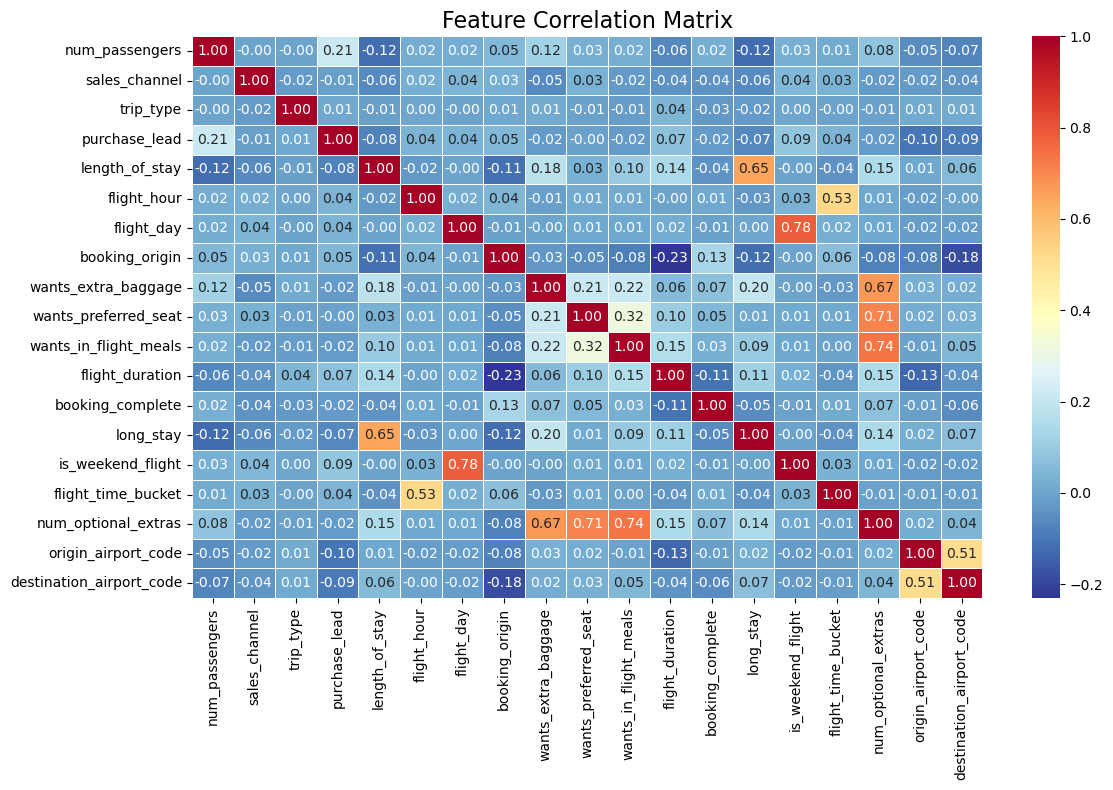

In [37]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='RdYlBu_r', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

### Train a Machine Learning Model

In [38]:
# Define target
target = 'booking_complete'

# Define features drop target
features = df.drop(columns=[target])

# Separate X and y
X = features
y = df[target]

In [39]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Train a RandomForest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
# Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

Accuracy: 0.8562
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.57      0.12      0.20      1480

    accuracy                           0.86     10000
   macro avg       0.72      0.55      0.56     10000
weighted avg       0.82      0.86      0.81     10000

CV Accuracy: 0.5167400000000001


In [42]:
df['booking_complete'].value_counts(normalize=True)

booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64

### Fix the Imbalance

In [43]:
# Use class_weight='balanced' in RandomForest
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
# Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

Accuracy: 0.8566
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.59      0.11      0.18      1480

    accuracy                           0.86     10000
   macro avg       0.72      0.55      0.55     10000
weighted avg       0.82      0.86      0.81     10000

CV Accuracy: 0.54838


In [45]:
# use Resampling (SMOTE, RandomOverSampler, RandomUnderSampler)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [46]:
# Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      8520
           1       0.38      0.34      0.36      1480

    accuracy                           0.82     10000
   macro avg       0.63      0.62      0.63     10000
weighted avg       0.81      0.82      0.82     10000

CV Accuracy: 0.5167400000000001


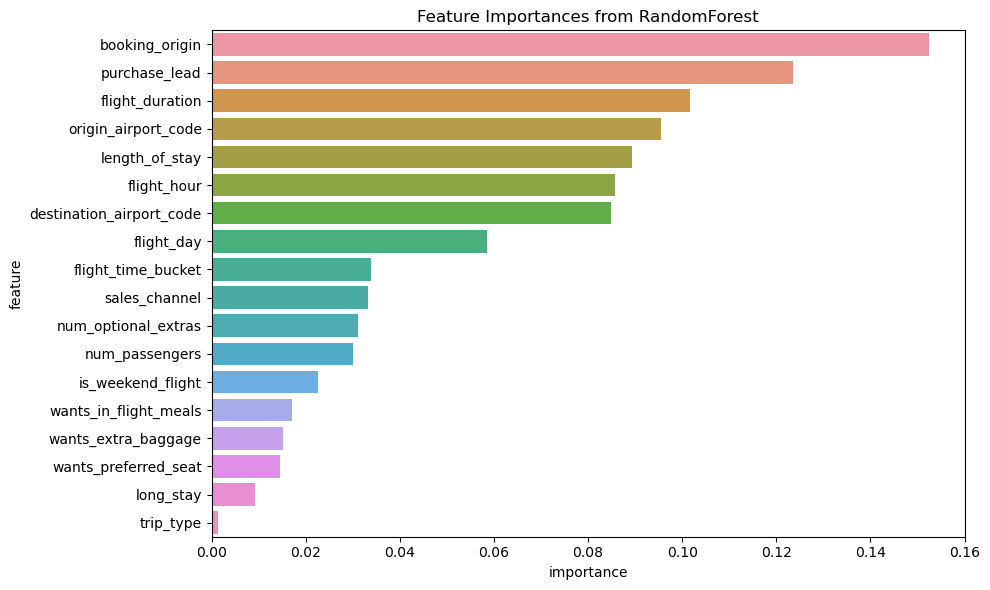

In [47]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_df)
plt.title('Feature Importances from RandomForest')
plt.tight_layout()
plt.show()

In [48]:
# use Resampling (SMOTE, RandomOverSampler, RandomUnderSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [49]:
# Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

Accuracy: 0.8446
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8520
           1       0.45      0.23      0.30      1480

    accuracy                           0.84     10000
   macro avg       0.66      0.59      0.61     10000
weighted avg       0.81      0.84      0.82     10000

CV Accuracy: 0.5167400000000001


In [50]:
# use Resampling (SMOTE, RandomOverSampler, RandomUnderSampler)
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [51]:
# Evaluate Model

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("CV Accuracy:", cv_scores.mean())

Accuracy: 0.6844
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      8520
           1       0.28      0.74      0.41      1480

    accuracy                           0.68     10000
   macro avg       0.61      0.71      0.60     10000
weighted avg       0.84      0.68      0.73     10000

CV Accuracy: 0.5167400000000001


### Feature Importance Visualization

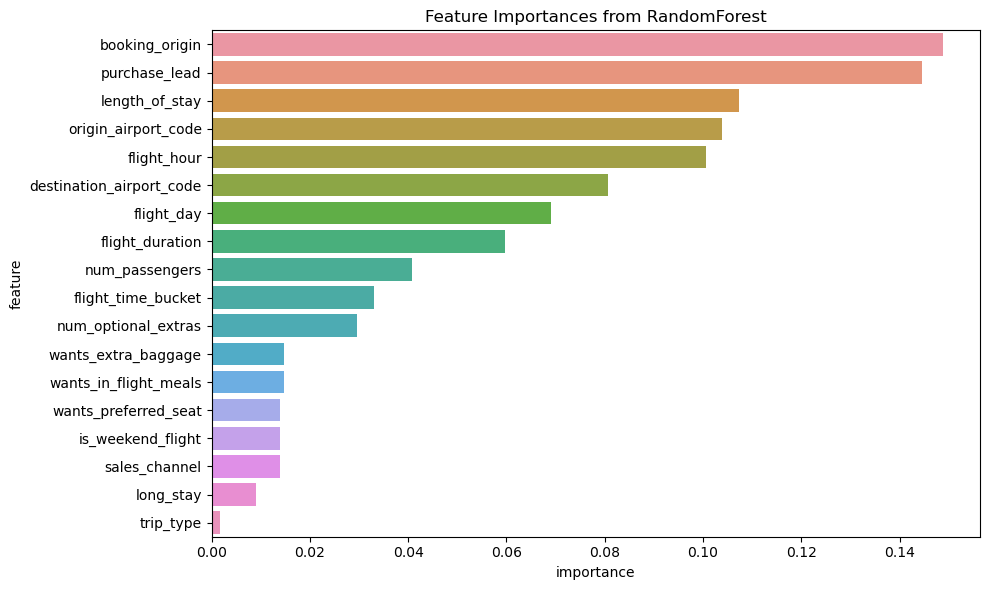

In [52]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_df)
plt.title('Feature Importances from RandomForest')
plt.tight_layout()
plt.show()

### Final Results

| Sampling Method       | Accuracy | Precision (1) | Recall (1) | F1 (1) | CV Accuracy | Notes                                                      |
| --------------------- | -------- | ------------- | ---------- | ------ | ----------- | ---------------------------------------------------------- |
| No balancing          | 0.8562   | 0.57          | 0.12       | 0.20   | 0.5167      | High accuracy, **very poor recall** on class `1`.          |
| Class-weight balanced | 0.8566   | 0.59          | 0.11       | 0.18   | 0.5484      | Same issue: still **very poor recall** on class `1`.       |
| SMOTE                 | 0.8200   | 0.38          | 0.34       | 0.36   | 0.5167      | Moderate trade-off between precision & recall. Better F1.  |
| Random Over Sampling  | 0.8446   | 0.45          | 0.23       | 0.30   | 0.5167      | Better than unbalanced, still not ideal.                   |
| Random Under Sampling | 0.6844   | 0.28          | **0.74**   | 0.41   | 0.5167      | **Highest recall**, but much lower precision and accuracy. |


Note that we can enhnace the performance of the model by performing hyperparameter optimization.